In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym

import gym_env
from models import LinearRL_NHB

In [3]:
# Save dir
save_dir = os.path.join('..', 'figures/')

## Plot Difference between $M[s_0, s_1]$ and $M[s_0, s_2]$ to show SR bias

### Make simple environment and transition policies

In [4]:
## Construct a simple environment
envstep=[]
for s in range(3):
    # actions 0=left, 1=right
    envstep.append([[0,0], [0,0]])  # [s', done]
envstep = np.array(envstep)
# State 0 -> 1, 2
envstep[0,0] = [1,0]
envstep[0,1] = [2,0]

# State 1 -> 3
envstep[1,0] = [3,1]
envstep[1,1] = [3,1]

# State 2 -> 4
envstep[2,0] = [4,1]
envstep[2,1] = [4,1]

## Construct a biased policy
T_b = np.zeros((5,5))
# State 3 is more rewarding than state 4 so we will incorporate that preference into the policy
T_b[0,1] = 0.8
T_b[0,2] = 0.2
T_b[1,3] = 1.0
T_b[2,4] = 1.0
T_b[3,3] = 1.0
T_b[4,4] = 1.0

## The unbiased transition policy
T = np.zeros((5,5))
T[0,1] = 0.5
T[0,2] = 0.5
T[1,3] = 1.0
T[2,4] = 1.0
T[3,3] = 1.0
T[4,4] = 1.0

### Define Useful Functions

In [5]:
def softmax(state, T, V, envstep):
    successor_states = np.where(T[state, :] != 0)[0]
    action_probs = np.full(2, 0.0)   # We can hardcode this because every state has 2 actions

    v_sum = sum(np.exp(V[s] / 1.0) for s in successor_states)

    # if we don't have enough info, random action
    if v_sum == 0:
        return  np.random.choice([0,1])

    for action in [0,1]:
        new_state, done = envstep[state, action]

        # If we hit a done state our action doesn't matter
        if done:
            action = np.random.choice([0,1])
            return action, 1
        action_probs[action] = np.exp(V[new_state] / 1.0 ) / v_sum
        
    action = np.random.choice([0,1], p=action_probs)
    s_prob = action_probs[action]

    return action, s_prob

def imp_sampling(T, state, s_prob):
    successor_states = np.where(T[state, :] != 0)[0]
    p = 1/len(successor_states)
    w = p/s_prob
            
    return w

def train_SR(num_steps, alpha, gamma, r, imp_samp):
    M = np.eye(5)
    one_hot = np.eye(5)
    state = 0
    diffs = []
    for _ in range(num_steps):
        V = M @ r
        action, s_prob = softmax(state, T, V, envstep)
        if imp_samp:
            w = imp_sampling(T, state, s_prob)
        else:
            w = 1

        # Take action
        next_state, done = envstep[state, action]

        # Update SR
        target = one_hot[state] + gamma * M[next_state]
        M[state] = (1 - alpha) * M[state] + alpha * target * w

        diffs.append(np.square(M[0][1] - M[0][2]))

        if done:
            state = 0
            continue
        
        state = next_state
    
    return M, diffs

### Train SR agents

In [6]:
# Define parameters
num_steps = 12000
num_simulations = 20
alpha = 0.01
gamma = 0.3
r = np.array([0,0,0,10,2])

In [7]:
diffs_all_without, diffs_all_with = [], []
for seed in np.arange(num_simulations):
    np.random.seed(int(seed))
    M_without, diffs_without = train_SR(num_steps, alpha, gamma, r, imp_samp=False)
    M_with, diffs_with = train_SR(num_steps, alpha, gamma, r, imp_samp=True)
    diffs_all_without.append(diffs_without)
    diffs_all_with.append(diffs_with)
    print(f"seed: {seed}")

seed: 0
seed: 1
seed: 2
seed: 3
seed: 4
seed: 5
seed: 6
seed: 7
seed: 8
seed: 9
seed: 10
seed: 11
seed: 12
seed: 13
seed: 14
seed: 15
seed: 16
seed: 17
seed: 18
seed: 19


### Plot Differences

In [8]:
import seaborn as sns
palette = sns.color_palette("colorblind")

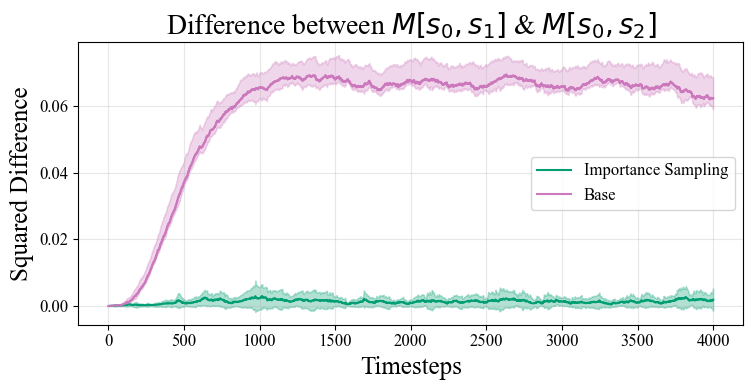

In [13]:
# Save path
save_path = save_dir + "s1s2_diff.png"
# save_path = None

# Define the number of timesteps to plot
num_timesteps = 4000  # You can change this to 6000, 8000, or any other value up to 12000

# Convert lists to numpy arrays for easier calculations
arr_with = np.array(diffs_all_with)
arr_without = np.array(diffs_all_without)

# Calculate means and standard deviations
mean_with = np.mean(arr_with[:, :num_timesteps], axis=0)
std_with = np.std(arr_with[:, :num_timesteps], axis=0)
mean_without = np.mean(arr_without[:, :num_timesteps], axis=0)
std_without = np.std(arr_without[:, :num_timesteps], axis=0)

# Create x-axis (timesteps)
timesteps = np.arange(1, num_timesteps + 1)

# Set up the plot style
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# Create the plot with adjusted figure size
fig, ax = plt.subplots(figsize=(8, 4))  # Adjusted to be longer and shorter

# Plot mean and variance for 'with' data
ax.plot(timesteps, mean_with, label='Importance Sampling', color=palette[2])
ax.fill_between(timesteps, mean_with - std_with, mean_with + std_with, 
                alpha=0.3, color=palette[2])

# Plot mean and variance for 'without' data
ax.plot(timesteps, mean_without, label='Base', color=palette[4])
ax.fill_between(timesteps, mean_without - std_with, mean_without + std_without, 
                alpha=0.3, color=palette[4])

# Customize the plot
ax.set_xlabel('Timesteps', fontsize=18)
ax.set_ylabel('Squared Difference', fontsize=18)
ax.set_title(r'Difference between $M[s_0,s_1]$ & $M[s_0,s_2]$', fontsize=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

# Adjust tick label font size
ax.tick_params(axis='both', which='major', labelsize=12)

# Improve layout
plt.tight_layout()
plt.subplots_adjust(left=0.15)

if save_path is not None:
    plt.savefig(save_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Hardcode a SR with specific actions to show how importance sampling works

### Define starting SR

In [14]:
M_with = np.array([
    [0, 0.5, 0.5, 0, 0],
    [0, 1, 0, 0.2, 0],
    [0, 0, 1, 0, 0.3],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1]
])

M_without= np.copy(M_with)
r = np.array([0,0,0,10,2])
V = M_with @ r

### Have SR take actions and record all the different values for each action

In [15]:
alpha = 0.3
gamma = 1.0
r = np.array([0,0,0,10,2])

state = 0
one_hot = np.eye(5)
num_actions = 30
actions = [0, 0, 1, 0]
next_states = [1,2]

# Holders for data
base_s0s1, base_s0s2, impsamp_s0s1, impsamp_s0s2 = [], [], [], [] 
target_base_s0s1, target_base_s0s2, target_impsamp_s0s1, target_impsamp_s0s2 = [], [], [], [], 

print("Beginning...")
print(f"M_with[s0]: {M_with[0]}")
print(f"M_without[s0]: {M_without[0]} \n")

# base_s0s1.append(M_without[0,1])
# base_s0s2.append(M_without[0,2])
# impsamp_s0s1.append(M_with[0,1])
# impsamp_s0s2.append(M_with[0,2])

# target_base_s0s1.append(0)
# target_base_s0s2.append(0)
# target_impsamp_s0s1.append(0)
# target_impsamp_s0s2.append(0)

for i, action in enumerate(actions):
    V_with = M_with @ r
    V_without = M_without @ r

    # Take action
    next_state, _ = envstep[state, action]

    # get probabilities of taking the action
    prob_with = np.exp(V_with[next_states[action]]) / (np.exp(V_with[next_states[action]]) + np.exp(V_with[next_states[1-action]]))

    # Importance sampling
    w = imp_sampling(T, state, prob_with)

    # Update base SR
    target_without = one_hot[state] + gamma * M_without[next_state]
    M_without[state] = (1 - alpha) * M_without[state] + alpha * target_without

    # Update importance sampling
    target_with = one_hot[state] + gamma * M_with[next_state]
    M_with[state] = (1 - alpha) * M_with[state] + alpha * target_with * w

    # print(f"Action: {action}")
    # print(f"M_with[s0]: {M_with[0]} | w: {w}")
    # print(f"M_without[s0]: {M_without[0]}")
    # print(f"target base: {target_with} | target importance: {target_with * w}\n")

    # Update data holders
    base_s0s1.append(M_without[0,1])
    base_s0s2.append(M_without[0,2])
    impsamp_s0s1.append(M_with[0,1])
    impsamp_s0s2.append(M_with[0,2])

    target_base_s0s1.append(target_with[1])
    target_base_s0s2.append(target_with[2])
    target_impsamp_s0s1.append(target_with[1]*w)
    target_impsamp_s0s2.append(target_with[2]*w)

print("Final:")
print(f"M_with[s0]: {M_with[0]}")
print(f"M_without[s0]: {M_without[0]} \n")
data_s0s1 = [base_s0s1, impsamp_s0s1, target_base_s0s1, target_impsamp_s0s1]
data_s0s2 = [base_s0s2, impsamp_s0s2, target_base_s0s2, target_impsamp_s0s2]

Beginning...
M_with[s0]: [0.  0.5 0.5 0.  0. ]
M_without[s0]: [0.  0.5 0.5 0.  0. ] 

Final:
M_with[s0]: [0.87354783 0.46280184 0.650846   0.06855037 0.1592388 ]
M_without[s0]: [0.7599  0.66995 0.33005 0.10998 0.063  ] 



### Plot the results in a bar plot

In [19]:
def plot_data(data, title, legend=True, save_path=None):
    plt.rcParams['font.family'] = 'serif'
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Define colors
    colors = [
        (0.8, 0.47058823529411764, 0.7372549019607844),  # base
        (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),  # importance sampling
        'salmon',  # target - base
        (0.8, 0.8, 1.0)  # target - importance sampling (periwinkle)
    ]
    
    labels = ['Base', 'Importance Sampling', 'Target - Base', 'Target - Importance Sampling']
    
    # Set width of each bar and positions
    bar_width = 0.2
    num_actions = len(data[0])
    
    for i, (values, color, label) in enumerate(zip(data, colors, labels)):
        positions = np.arange(num_actions) + i * bar_width
        plt.bar(positions, values, color=color, edgecolor='black', width=bar_width, label=label)
    
    # Labeling
    plt.xlabel('Action Steps', fontsize=18)
    plt.ylabel('Values', fontsize=18)
    plt.title(title, fontsize=22)
    plt.xticks(np.arange(num_actions) + bar_width*1.5, [f'Action {i}' for i in range(num_actions)], fontsize=16)
    
    # Create legend
    if legend:
        plt.legend(fontsize=12)

    # Save figure
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        
    # Show plot
    plt.tight_layout()
    plt.show()

In [22]:
# Create the plots
# plot_data(data_s0s1, 'M[s0, s1]', save_path=save_dir+"imp_samp_bar_supp.png")

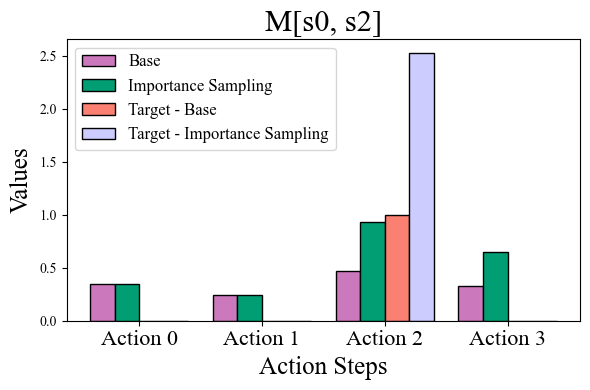

In [70]:
plot_data(data_s0s2, 'M[s0, s2]', save_path=save_dir+"imp_samp_bar.png")